# 1. Transfer Learning for Image Classification

# (a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. 

Text data is in 20 different files


# (b) Data Exploration and Pre-processing

    i. Images in each class are given in separate folders. The  file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.

    ii. Randomly select [0.17n]images from each folder as your training set, 0.15n as validation set, and the rest as your test set, where ni is the number of images in folder i and [x] is the ceiling of x.

    iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

# Libraries

In [40]:
import os
import random
import math
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from numpy.random import shuffle
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow as tf
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import EfficientNetB0


In [2]:
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import pandas as pd

# Load the Excel file
class_data = pd.read_excel('Classes.xlsx')

# Print out the actual column names
print(class_data.columns)


Index(['Folder Name ', 'Class'], dtype='object')


In [4]:
main_directory = './images'

# Initialize a list to hold the class names and image counts
class_image_data = []

# Loop through each subdirectory in the main directory
for class_dir in os.listdir(main_directory):
    # Construct the full path to the class directory
    dir_path = os.path.join(main_directory, class_dir)
    
    # Ensure that we're looking at a directory
    if os.path.isdir(dir_path):
        # Count the number of image files in the class directory
        # Assuming image files have typical extensions, adjust as needed
        image_files = [f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        # Append the class name and image count to the list
        class_image_data.append([class_dir, len(image_files)])

# Create a DataFrame from the list
df = pd.DataFrame(class_image_data, columns=['Class Name', 'Number of Images'])

# Sort the DataFrame by class name
df = df.sort_values('Class Name')

# Set index to start from 1 instead of 0
df.index = range(1, len(df) + 1)

# Display the DataFrame as a table
print(df)


                       Class Name  Number of Images
1              005.Crested_Auklet                44
2                    013.Bobolink                60
3              015.Lazuli_Bunting                58
4            023.Brandt_Cormorant                59
5      040.Olive_sided_Flycatcher                60
6   041.Scissor_tailed_Flycatcher                60
7            067.Anna_Hummingbird                60
8             072.Pomarine_Jaeger                60
9             076.Dark_eyed_Junco                60
10            081.Pied_Kingfisher                60
11          082.Ringed_Kingfisher                60
12               086.Pacific_Loon                60
13                   099.Ovenbird                60
14             104.American_Pipit                60
15           127.Savannah_Sparrow                60
16               135.Bank_Swallow                59
17                 141.Artic_Tern                58
18             149.Brown_Thrasher                59
19          

In [5]:
total_images = df['Number of Images'].sum()
print("Total number of images in dataset =", total_images)

Total number of images in dataset = 1236


In [6]:
path = './images/'
splitfolders.ratio(path, output='output', seed=1337, ratio=(0.715,0.16,0.125))

Copying files: 1236 files [00:03, 333.81 files/s]


In [7]:
# Load class names from Classes.xlsx
class_data = pd.read_excel('Classes.xlsx')
valid_class_names = class_data['Folder Name '].tolist()

# Initialize the ImageDataGenerator with data augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

# Directory where the training set is located
train_dir = "./output/train"

# Get a list of actual folder names in the train directory
actual_folders = os.listdir(train_dir)

# Filter out folders that are not listed in Classes.xlsx
valid_folders = [folder for folder in actual_folders if folder in valid_class_names]

# Generate batches of augmented image data with valid classes only
train_images = train_datagen.flow_from_directory(
    directory=train_dir,
    classes=valid_folders,  
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=5,
    shuffle=True
)

# Check the mapping of classes to ensure it matches Classes.xlsx
print(train_images.class_indices)


Found 827 images belonging to 20 classes.
{'005.Crested_Auklet': 0, '015.Lazuli_Bunting': 1, '156.White_eyed_Vireo': 2, '081.Pied_Kingfisher': 3, '135.Bank_Swallow': 4, '086.Pacific_Loon': 5, '067.Anna_Hummingbird': 6, '076.Dark_eyed_Junco': 7, '149.Brown_Thrasher': 8, '127.Savannah_Sparrow': 9, '041.Scissor_tailed_Flycatcher': 10, '141.Artic_Tern': 11, '082.Ringed_Kingfisher': 12, '099.Ovenbird': 13, '013.Bobolink': 14, '104.American_Pipit': 15, '023.Brandt_Cormorant': 16, '168.Kentucky_Warbler': 17, '072.Pomarine_Jaeger': 18, '040.Olive_sided_Flycatcher': 19}


In [8]:
val_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

# Directory where the validation set is located
val_dir = "./output/val"

val_images = val_datagen.flow_from_directory(
    directory=val_dir,
    classes=valid_folders,  # Specify class subdirectories to use
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=5,
    shuffle=True
)

# Check the mapping of classes to ensure it matches Classes.xlsx for the validation set
print(val_images.class_indices)


Found 178 images belonging to 20 classes.
{'005.Crested_Auklet': 0, '015.Lazuli_Bunting': 1, '156.White_eyed_Vireo': 2, '081.Pied_Kingfisher': 3, '135.Bank_Swallow': 4, '086.Pacific_Loon': 5, '067.Anna_Hummingbird': 6, '076.Dark_eyed_Junco': 7, '149.Brown_Thrasher': 8, '127.Savannah_Sparrow': 9, '041.Scissor_tailed_Flycatcher': 10, '141.Artic_Tern': 11, '082.Ringed_Kingfisher': 12, '099.Ovenbird': 13, '013.Bobolink': 14, '104.American_Pipit': 15, '023.Brandt_Cormorant': 16, '168.Kentucky_Warbler': 17, '072.Pomarine_Jaeger': 18, '040.Olive_sided_Flycatcher': 19}


In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_dir = "./output/test"
test_images = test_datagen.flow_from_directory(
    directory=test_dir,
    classes=valid_folders,  # Specify class subdirectories to use
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=5,
    shuffle=False  # Usually, you don't shuffle the test data
)
print(test_images.class_indices)

Found 171 images belonging to 20 classes.
{'005.Crested_Auklet': 0, '015.Lazuli_Bunting': 1, '156.White_eyed_Vireo': 2, '081.Pied_Kingfisher': 3, '135.Bank_Swallow': 4, '086.Pacific_Loon': 5, '067.Anna_Hummingbird': 6, '076.Dark_eyed_Junco': 7, '149.Brown_Thrasher': 8, '127.Savannah_Sparrow': 9, '041.Scissor_tailed_Flycatcher': 10, '141.Artic_Tern': 11, '082.Ringed_Kingfisher': 12, '099.Ovenbird': 13, '013.Bobolink': 14, '104.American_Pipit': 15, '023.Brandt_Cormorant': 16, '168.Kentucky_Warbler': 17, '072.Pomarine_Jaeger': 18, '040.Olive_sided_Flycatcher': 19}


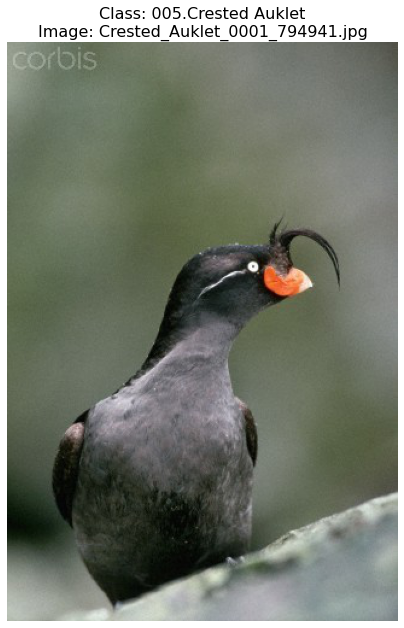

In [10]:
#choose the training directory to pick an image from
train_dir = './output/train'

# Pick a class folder
class_folders = os.listdir(train_dir)
chosen_class = class_folders[0]  # Let's take the first class for example

# List all images in this folder
class_images = os.listdir(os.path.join(train_dir, chosen_class))
if not class_images:
    print(f"No images found in {chosen_class} folder.")
else:
    # Choose a random image
    image_name = random.choice(class_images)

    # Construct the full image path
    image_path = os.path.join(train_dir, chosen_class, image_name)

    # Load the image
    image = mpimg.imread(image_path)

    # Display the image with a larger figure size
    plt.figure(figsize=(7, 15))
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title(f"Class: {chosen_class.replace('_', ' ')}\nImage: {image_name}", fontsize=16)
    plt.show()


    
# (c) Transfer Learning
    i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.
    
    ii. To perform empirical regularization, crop, randomly zoo, rotate, ip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

    iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

    iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs( preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.
    
    v. Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.


# VGG16 Model

In [11]:
# VGG16, like many models, requires a fixed-size input, and here we're using 256x256 pixels.
image_size = [256, 256] #image size for input to the VGG16 model.

# Initialize the VGG16 model.
# The model is being loaded with pre-trained weights from ImageNet, a large visual dataset used for training.
vgg = VGG16(
    input_shape=image_size + [3],  # Define the input shape. [3] refers to the three color channels (RGB).
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False  # Do not include the fully connected layer at the top of the network.
                       # This is because we usually want to add our own fully connected layers 
                       # tailored to our number of classes.
)

# Set the VGG16 model's layers to be non-trainable so the model can use as a fixed feature extractor, 
# and we don't want to update the weights of the pre-trained layers during training.
vgg.trainable = False


2024-01-05 13:03:08.815094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Get the output of the last layer of the VGG16 model.
# This output is used as the starting point for the new layers that you will add.
last_output = vgg.layers[-1].output

# Add a Global Average Pooling (GAP) layer.
# GAP is used to reduce the spatial dimensions of the input without losing the depth of the feature maps.
# It averages out the spatial information, thus reducing the total number of weights in the model.
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)

# Add a fully connected (Dense) layer with 1024 units and ReLU activation.
# This layer is used to learn more complex combinations of the high-level features as derived from the previous layers.
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Add a Batch Normalization layer.
# Batch Normalization normalizes the output of the previous layer by adjusting and scaling the activations.
# It helps to speed up training and can lead to faster convergence.
x = tf.keras.layers.BatchNormalization()(x)

# Add a Dropout layer at 20%.
# Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.
# During training, some number of layer outputs are randomly ignored or "dropped out" to prevent overfitting.
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final Dense layer with softmax activation.
# The model outputs 20 units, which is the number of classes for the classification task.
# Softmax activation enables us to calculate the probability distribution of the event over 'n' different events.
x = tf.keras.layers.Dense(20, activation='softmax')(x)

# Construct the new model.
# Here we are creating a new model (model_vgg) by adding the Dense layers we've just created to the original VGG16 model (vgg).
model_vgg = Model(inputs=vgg.input, outputs=x)

# Output the summary of the model.
# The summary provides a quick overview of the model architecture, showing the layers and their order,
# the output shapes and the number of parameters at each layer, and the total parameters in the model.
model_vgg.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
from keras import optimizers

# Initialize the Adam optimizer.
# Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
# procedure to update network weights iteratively based on training data. Adam optimization is a stochastic 
# gradient descent method that is based on adaptive estimation of first-order and second-order moments.
adam = optimizers.Adam()

# Compile the model.
# This step configures the model for training by defining the loss function, the optimizer, and the metrics.
model_vgg.compile(
    loss='categorical_crossentropy',  # Use categorical_crossentropy as the loss function,
    # which is suitable for multi-class classification problems where each example belongs to a single class.
    # The function expects labels to be provided in a 'one-hot' encoded format.
    
    optimizer=adam,  # Specify the Adam optimizer for adjusting the weights during training,
    # which has been shown to be effective and efficient for a wide range of models and problems.
    
    metrics=['accuracy']  # Specify 'accuracy' as a metric to evaluate during training and testing.
    # Accuracy calculates how often predictions equal labels, which is a common metric for classification.
)


In [14]:
# Print the total number of images in the training dataset
print("Size of training dataset:", train_images.n)

# Print the total number of images in the validation dataset
print("Size of validation dataset:", val_images.n)

# This will give you an idea of the input dimensions (image size and batch size)
if train_images.n > 0:
    x, y = next(train_images)
    print("Shape of a single batch of training data (images):", x.shape)
    print("Shape of a single batch of training data (labels):", y.shape)

if val_images.n > 0:
    x, y = next(val_images)
    print("Shape of a single batch of validation data (images):", x.shape)
    print("Shape of a single batch of validation data (labels):", y.shape)


Size of training dataset: 827
Size of validation dataset: 178
Shape of a single batch of training data (images): (5, 256, 256, 3)
Shape of a single batch of training data (labels): (5, 20)
Shape of a single batch of validation data (images): (5, 256, 256, 3)
Shape of a single batch of validation data (labels): (5, 20)


In [15]:

# Initialize a ModelCheckpoint callback.
# This callback saves the model at every epoch where there's an improvement in 'val_accuracy'.
checkpoint = ModelCheckpoint(
    filepath='mymodel.h5',  # Name of the file where the model will be saved.
    verbose=2,  # Verbosity mode, 2 will print messages when the callback takes an action.
    save_best_only=True,  # Only save a model if 'val_accuracy' has improved.
    monitor='val_accuracy'  # Monitor 'val_accuracy' for improvements.
)

# Initialize an EarlyStopping callback.
# This callback stops training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor='loss',  # Monitor the training loss.
    patience=5  # Number of epochs with no improvement after which training will be stopped.
)

# List of callbacks to be used during training.
callbacks = [checkpoint, early_stop]

# Record the start time for calculating total training time.
start = datetime.now()

# Fit the model on the data provided by train_images and validate using val_images.
# The model trains for a fixed number of epochs (iterations on a dataset).
model_history = model_vgg.fit(
    train_images,  # Training data
    validation_data=val_images,  # Validation data
    epochs=50,  # Number of epochs to train the model.
    verbose=2,  # Verbosity mode; 2 will print one line per epoch.
    callbacks=[checkpoint, early_stop]  # List of callbacks to apply during training.
)

# Calculate and print the training duration.
duration = datetime.now() - start
print('Training completed in time: ', duration)


Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.56180, saving model to mymodel.h5
166/166 - 485s - loss: 1.9195 - accuracy: 0.4667 - val_loss: 1.5108 - val_accuracy: 0.5618 - 485s/epoch - 3s/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.56180 to 0.61798, saving model to mymodel.h5
166/166 - 352s - loss: 1.0714 - accuracy: 0.6977 - val_loss: 1.2637 - val_accuracy: 0.6180 - 352s/epoch - 2s/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.61798 to 0.73596, saving model to mymodel.h5
166/166 - 371s - loss: 0.8595 - accuracy: 0.7364 - val_loss: 0.8801 - val_accuracy: 0.7360 - 371s/epoch - 2s/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.73596
166/166 - 340s - loss: 0.8008 - accuracy: 0.7437 - val_loss: 0.9553 - val_accuracy: 0.7022 - 340s/epoch - 2s/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.73596
166/166 - 317s - loss: 0.7519 - accuracy: 0.7606 - val_loss: 1.0848 - val_accuracy: 0.6517 - 317s/epoch - 2s/step
Epoch 6/50

Epoch 6: v

In [19]:
# Load the previously saved weights into the model.
#useful for trained a model, saved its weights, and need to reload them to make predictions or continue training.
model_vgg.load_weights('mymodel.h5')

# Make predictions on the test dataset.
# The 'predict' method of the model is used to get the predictions for each image in the test dataset.
# It outputs the raw probabilities of each class for each image.
pred = model_vgg.predict(test_images)

# Determine the predicted class for each image.
# 'argmax' is used to find the index of the maximum value in each prediction, which corresponds to the most likely class.
# The axis=-1 parameter specifies that the argmax should be calculated in the last dimension, which is where the class probabilities are.
pred_class = pred.argmax(axis=-1)

# Get the true class labels for the test dataset.
# 'classes' attribute of the test_images data generator contains the true class labels for each image in the test dataset.
# These labels are in the same order as the images are loaded by the data generator and thus can be directly compared with the predictions.
true_class = test_images.classes


35/35 [==============================] - 81s 2s/step


In [20]:
vgg_acc = accuracy_score(true_class, pred_class)
print("VGG16 Model Accuracy: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy: 80.70%


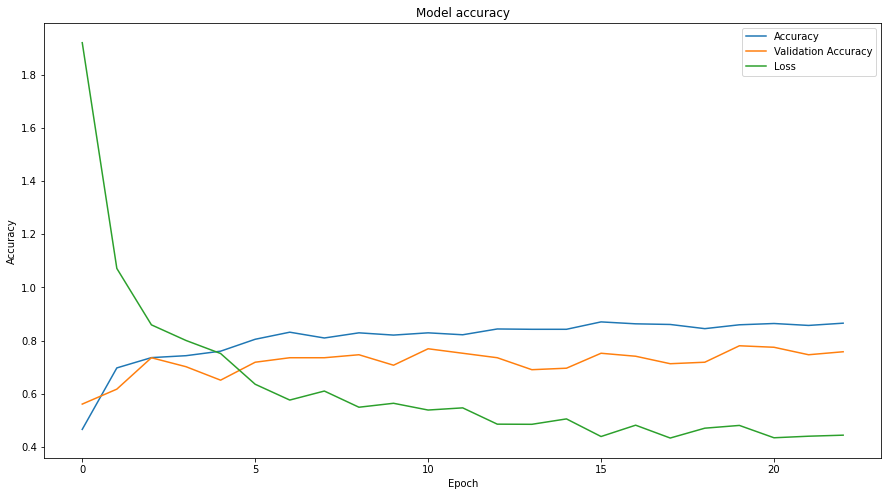

In [25]:
#plots the training history of a neural network model, specifically illustrating its accuracy and loss over epochs. 
#shows how the accuracy and loss metrics evolve as the number of epochs increases, which can be helpful for diagnosing issues 
#with training, like overfitting or underfitting, and for deciding if further training is necessary or if the learning rate should be adjusted.
# Create a figure for plotting with a specified size
fig = plt.figure(figsize=(15, 8))

# Plot the accuracy of the model on the training data
plt.plot(model_history.history["accuracy"], label="Accuracy")

# Plot the accuracy of the model on the validation data
plt.plot(model_history.history['val_accuracy'], label="Validation Accuracy")

# Plot the loss of the model on the training data
plt.plot(model_history.history['loss'], label="Loss")

# Set the title of the plot to "Model accuracy"
plt.title("Model accuracy")

# Set the y-axis label of the plot to "Accuracy"
plt.ylabel("Accuracy")

# Set the x-axis label of the plot to "Epoch"
plt.xlabel("Epoch")

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


In [28]:
 print(classification_report(true_class, pred_class))


              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      1.00      1.00         8
           2       0.64      0.78      0.70         9
           3       0.90      1.00      0.95         9
           4       0.50      0.62      0.56         8
           5       1.00      0.78      0.88         9
           6       1.00      1.00      1.00         9
           7       0.78      0.78      0.78         9
           8       0.71      0.62      0.67         8
           9       0.86      0.67      0.75         9
          10       0.75      0.67      0.71         9
          11       0.89      1.00      0.94         8
          12       1.00      0.89      0.94         9
          13       1.00      0.67      0.80         9
          14       0.80      0.89      0.84         9
          15       0.57      0.89      0.70         9
          16       1.00      0.75      0.86         8
          17       1.00    

# EfficientNetB0

In [41]:
# Load the EfficientNetB0 model pre-trained on ImageNet, excluding the top layer
mod = EfficientNetB0(weights='imagenet', include_top=False)
mod.trainable = False

# Build the final model
last_output = mod.layers[-1].output
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(20, activation='softmax')(x)
final_mod = Model(mod.input, x)

# Compile the final model
final_mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Define callbacks
path = 'efnet.h5'
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=5)

start = datetime.now()

# Fit the model
efnet_hist = final_mod.fit(
    train_images, 
    epochs=50, 
    validation_data=val_images, 
    callbacks=[checkpoint, early_stopping], 
    verbose=1
)

# Print the model summary
final_mod.summary()


# Calculate and print the training duration.
duration = datetime.now() - start
print('Training completed in time: ', duration)


Epoch 1/50
166/166 [==============================] - ETA: 0s - loss: 2.5389 - acc: 0.2527
Epoch 1: val_acc improved from -inf to 0.38202, saving model to efnet.h5


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [33]:
mod.load_weights(path) 
pred = mod.predict(test_images)
pred_class = pred.argmax(axis=-1)

true_class = test_images.classes

ValueError: Layer count mismatch when loading weights from file. Model expected 131 layers, found 0 saved layers.

In [38]:
import keras
keras.models.load_model('efnet.hdf5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x7fbe59cae1c0>.